In [ ]:
策略名稱:順勢交易

因好奇追漲殺跌是否是一個有效的策略而嘗試使用KD指標來判斷趨勢
那因此這是就根據KD指標來寫出一個專門追高跟殺低的策略
那這次策略是多空都做，希望不會變成多空雙巴

本次策略採用指標
KD指標（英文：Stochastic Oscillator），也稱為隨機指標，是技術分析常見的指標之一，主要用於判斷股價短期的強弱程度與可能反轉的時機。KD 指標的數值介於 0-100，一般以 50 作為分水嶺，當指標大於 50 時，表示股價處於強勢階段；反之，當股價小於 50 時，股價屬於弱勢階段。另外，當 KD 指標小於 20 時，股票往往有超賣的跡象，隨時有反轉向上的可能；反之當 KD 指標大於 80 時，股票往往有超買的跡象，隨時有反轉向下的可能。因此，許多人依此來建構交易訊號，作為買賣股票的依據。

KD 指標的計算流程如下：

RSV = ( ( 當日收盤價 – 近 N 日的最低價 ) / ( 近 N 日的最高價 – 近 N 日的最低價 ) ) * 100
K 值 = 昨日 K 值 × ( 2 / 3 ) + 當日 RSV × ( 1 / 3 )
D 值 = 昨日 D 值 × ( 2 / 3 ) + 當日 K 值 × ( 1 / 3 )
從算式來看，可以把 RSV 解讀成當日股價相較於近 N 日股價，是屬於較強勢還是弱勢。K 值，又被稱為快線，因為受到當日股價強弱的影響較大；而 D 值計算的原理如同再進行一次平滑，故對當前股價變化反應較慢。

另外，算式中的 N 值為計算指標的移動窗格，可以根據不同的投資屬性而定。設定較大的 N 值可以使 KD 值趨於平穩，並因為基於較長的基期計算 KD 值，可使指標提供的反轉訊號較為精準，適合中長期的投資人。反之，較小的 N 值會使 KD 指標較為敏感，適合短期的投資人。

KD 指標策略
本文採用 KD 指標來判斷股價反轉時機，利用以下進出場規則建立交易策略並進行回測：

K ≤ 20  做空，因其代表股價較弱、市場過冷的狀態
K ≥ 30  回補，因為代表趨是有機會從極度弱勢轉回，所以要先回補
K ≥ 85  買入，代表市場過熱，因為根據策略我們得跟著趨勢走
k ≤ 75  賣出，代表開始趨勢可能要翻轉了，根據策略我們得賣出了

In [1]:
import os
import pandas as pd
import numpy as np
import tejapi
import matplotlib.pyplot as plt

In [2]:
os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'
os.environ['TEJAPI_KEY'] = 'EOCprUG3A6FZFta9iUPXWYu8JQgjmY'
os.environ['mdate'] = '20180101 20230526'
os.environ['ticker'] = '0050'

!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 61/1000 (6.1%)
Currently used TEJ API key data quota 25252/10000000 (0.25%)


[2024-05-26 10:54:29.669205] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-05-26 10:54:33.212674] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [3]:
from zipline.api import (set_slippage, 
                         set_commission, 
                         set_benchmark, 
                         attach_pipeline, 
                         symbol, 
                         pipeline_output,
                         record, 
                         order,
                         order_target
                        )
from zipline.pipeline.filters import StaticSids
from zipline.finance import slippage, commission
from zipline import run_algorithm
from zipline.pipeline import CustomFactor, Pipeline
from zipline.pipeline.data import EquityPricing
from zipline.pipeline.factors import ExponentialWeightedMovingAverage
from zipline.api import set_slippage, set_commission, set_benchmark, attach_pipeline, order, order_target, symbol, pipeline_output, record
from zipline.finance import commission, slippage
from zipline.data import bundles
from zipline import run_algorithm
from zipline.pipeline import Pipeline
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.factors import BollingerBands
from zipline.pipeline.data import EquityPricing
from zipline.sources.TEJ_Api_Data import get_universe
from zipline.pipeline.data import TWEquityPricing
from zipline.TQresearch.tej_pipeline import run_pipeline   

from zipline.api import *
from zipline.finance.commission import PerDollar
from zipline.finance.slippage import VolumeShareSlippage

from zipline.sources.TEJ_Api_Data import (get_Treasury_Return,
                                            get_Benchmark_Return)

import pyfolio as pf

plt.rcParams['axes.unicode_minus'] = False


In [290]:
from zipline.api import order, record, symbol, set_slippage, set_commission, attach_pipeline, pipeline_output
from zipline.pipeline import Pipeline
from zipline.pipeline.data import EquityPricing
from zipline.pipeline.factors import CustomFactor, ExponentialWeightedMovingAverage, BollingerBands
from zipline.finance import slippage, commission
import numpy as np

# 自定义因子: N天内最高价
class NdaysMaxHigh(CustomFactor):
    inputs = [EquityPricing.high]
    window_length = 8
    def compute(self, today, assets, out, highs):
        out[:] = np.nanmax(highs[:-1], axis=0)

# 自定义因子: N天内最低价
class NdaysMinLow(CustomFactor):
    inputs = [EquityPricing.low]
    window_length = 8
    def compute(self, today, assets, out, lows):
        out[:] = np.nanmin(lows[:-1], axis=0)

# 自定义KDJ
class FastStochasticOscillator(CustomFactor):
    inputs = [EquityPricing.close, EquityPricing.low, EquityPricing.high]
    window_length = 10

    def compute(self, today, assets, out, closes, lows, highs):
        lowest_lows = np.nanmin(lows, axis=0)
        highest_highs = np.nanmax(highs, axis=0)
        out[:] = 100 * (closes[-1] - lowest_lows) / (highest_highs - lowest_lows)

# 创建Pipeline
def make_pipeline():
    ema = ExponentialWeightedMovingAverage(
        inputs=[EquityPricing.close],
        window_length=7,
        decay_rate=1/7
    )
    high = NdaysMaxHigh()
    low = NdaysMinLow()
    close = EquityPricing.close.latest
    bollinger = BollingerBands(
        inputs=[EquityPricing.close],
        window_length=20,
        k=2
    )
    fast_stochastic = FastStochasticOscillator()

    return Pipeline(
        columns={
            'ema': ema,
            'highesthigh': high,
            'lowestlow': low,
            'latest': close,
            'upper': bollinger.upper,
            'middle': bollinger.middle,
            'lower': bollinger.lower,
            'curr_price': close,
            'FastStochasticOscillator': fast_stochastic,
        }
    )

# 初始化函数
def initialize(context):
    context.last_buy_price = 0
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.PerShare(cost=0.00285))
    set_benchmark(symbol('0050'))
    attach_pipeline(make_pipeline(), 'mystrategy')
    context.last_signal_price = 0

# 处理交易逻辑
def handle_data(context, data):
    pipe = pipeline_output('mystrategy')

    for i in pipe.index:
        ema = pipe.loc[i, 'ema']
        highesthigh = pipe.loc[i, 'highesthigh']
        lowestlow = pipe.loc[i, 'lowestlow']
        close = pipe.loc[i, 'latest']
        bias = close - ema
        residual_position = context.portfolio.positions[i].amount
        
        # 布林通道参数
        upper = pipe.loc[i, 'upper']
        middle = pipe.loc[i, 'middle']
        lower = pipe.loc[i, 'lower']
        curr_price = pipe.loc[i, 'curr_price']
        cash_position = context.portfolio.cash
        stock_position = context.portfolio.positions[i].amount
       
        # KD整合的条件
        short_kd = pipe.loc[i, 'FastStochasticOscillator']
        
        # 整合的条件
        hadbuy=0
        hadshort=0
        condition1 = (short_kd > 85) 
        condition2 = (short_kd < 75)
        condition3 = (short_kd < 20) 
        condition4 = (short_kd > 30) 
        buy, sell, short_sell, cover = False, False, False, False

        # 记录条件
        record(
            con1=condition1,
            con2=condition2,
            con3=condition3,
            con4=condition4,
            price=close,
            ema=ema,
            bias=bias,
            highesthigh=highesthigh,
            lowestlow=lowestlow,
            price2=curr_price,
            upper=upper,
            lower=lower,
            buy=buy,
            sell=sell,
            short_sell=short_sell,
            cover=cover
        )
        
        # Long position logic
        if stock_position == 0:
            if condition1 and cash_position > curr_price * 1000:
                order(i, 2000)
                context.last_signal_price = curr_price
                buy = True
                record(buy=buy)
        elif stock_position > 0:
            if condition1 and curr_price and cash_position >= curr_price * 2000:
                order(i, 2000)
                context.last_signal_price = curr_price
                buy = True
                record(buy=buy)
            elif condition2:
                order_target(i, 0)
                context.last_signal_price = 0
                sell = True
                record(sell=sell)
        
        # Short position logic
        if stock_position == 0:
            if condition3 and cash_position > curr_price * 1000:
                order(i, -2000)
                context.last_signal_price = curr_price
                short_sell = True
                record(short_sell=short_sell)
        elif stock_position < 0:
            if condition3 and cash_position >= curr_price * 2000:
                order(i, -2000)
                context.last_signal_price = curr_price
                short_sell = True
                record(short_sell=short_sell)
            elif condition4:
                order_target(i, 0)
                context.last_signal_price = 0
                cover = True
                record(cover=cover)



In [291]:
import matplotlib.pyplot as plt

def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel("Portfolio value (NTD)")
    
    ax2 = fig.add_subplot(212)
    ax2.set_ylabel("Price (NTD)")
    perf.price.plot(ax=ax2)
    
    # 繪製買入訊號
    ax2.plot(
        perf.index[perf.con2],
        perf.loc[perf.con2, 'price'],
        '^',
        markersize=5,
        color='red',
        label='Buy Signal'
    )
    
    # 繪製賣出訊號
    ax2.plot(
        perf.index[perf.con1],
        perf.loc[perf.con1, 'price'],
        'v',
        markersize=5,
        color='green',
        label='Sell Signal'
    )
    
    # 繪製做空訊號
    ax2.plot(
        perf.index[perf.short_sell],
        perf.loc[perf.short_sell, 'price'],
        'o',
        markersize=5,
        color='blue',
        label='Short Sell Signal'
    )
    
    # 繪製做空回補訊號
    ax2.plot(
        perf.index[perf.cover],
        perf.loc[perf.cover, 'price'],
        'x',
        markersize=10,
        color='purple',
        label='Cover Signal'
    )
    
    plt.legend(loc=0)
    plt.gcf().set_size_inches(18, 8)
    plt.show()


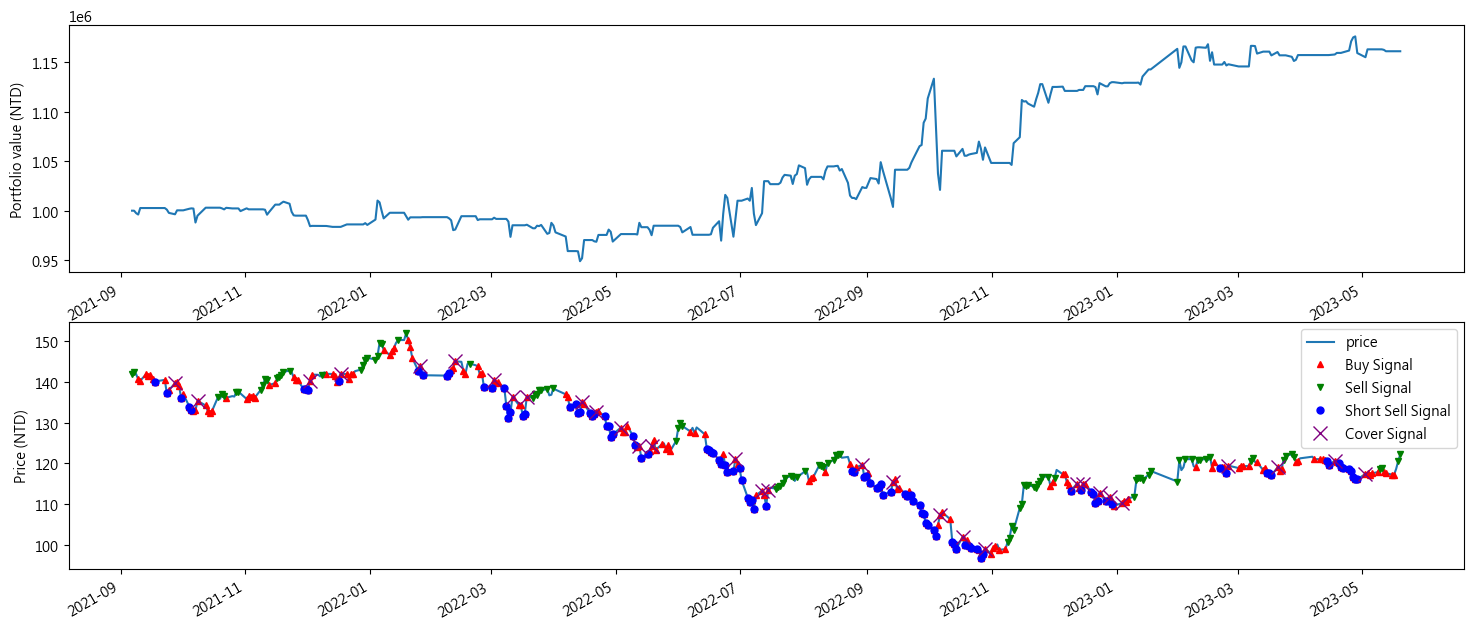

In [292]:
from zipline import run_algorithm


results = run_algorithm(start = pd.Timestamp('20210905', tz='UTC'),
                       end = pd.Timestamp('20230520', tz='UTC'),
                       initialize=initialize,
                       bundle='tquant',
                    
                       analyze=analyze,
                       capital_base=1e6,
                       handle_data = handle_data
                      )

In [293]:
results # 績效與交易明細

,period_open,period_close,short_exposure,ending_exposure,orders,benchmark_return,transactions,ending_cash,returns,capital_used,...,algorithm_period_return,algo_volatility,sharpe,trading_days,max_drawdown,alpha,beta,period_label,treasury_period_return,sortino
2021-09-06 13:30:00+08:00,2021-09-06 09:01:00+08:00,2021-09-06 13:30:00+08:00,0.0,0.0,"[{'id': 'f3b2c62c057b46bba62f2fcd1cf45a84', 'd...",0.004586,[],1.000000e+06,0.000000,0.000000,...,0.000000,NaN,NaN,1,0.000000,NaN,NaN,2021-09,0.0,NaN
2021-09-07 13:30:00+08:00,2021-09-07 09:01:00+08:00,2021-09-07 13:30:00+08:00,0.0,283800.0,"[{'id': 'f3b2c62c057b46bba62f2fcd1cf45a84', 'd...",-0.004565,"[{'amount': 2000, 'dt': 2021-09-07 13:30:00+08...",7.161943e+05,-0.000006,-283805.701604,...,-0.000006,0.000064,-11.224972,2,-0.000006,-0.000720,0.000623,2021-09,0.0,-11.224972
2021-09-08 13:30:00+08:00,2021-09-08 09:01:00+08:00,2021-09-08 13:30:00+08:00,0.0,562600.0,"[{'id': 'b147a7cefec8480ea140b54bc62275e2', 'd...",-0.008805,"[{'amount': 2000, 'dt': 2021-09-08 13:30:00+08...",4.348886e+05,-0.002506,-281305.702147,...,-0.002511,0.022939,-9.196451,3,-0.002511,-0.090545,0.157311,2021-09,0.0,-9.185982
2021-09-09 13:30:00+08:00,2021-09-09 09:01:00+08:00,2021-09-09 13:30:00+08:00,0.0,561200.0,"[{'id': 'bec0705683c943269229cc6daa301a13', 'd...",-0.002490,[],4.348886e+05,-0.001404,0.000000,...,-0.003911,0.019262,-12.804740,4,-0.003911,-0.127614,0.155090,2021-09,0.0,-10.819506
2021-09-10 13:30:00+08:00,2021-09-10 09:01:00+08:00,2021-09-10 13:30:00+08:00,0.0,0.0,"[{'id': 'bec0705683c943269229cc6daa301a13', 'd...",0.011757,"[{'amount': -4000, 'dt': 2021-09-10 13:30:00+0...",1.002677e+06,0.006614,567788.509308,...,0.002677,0.056428,2.411076,5,-0.003911,0.134853,0.390828,2021-09,0.0,6.672681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15 13:30:00+08:00,2023-05-15 09:01:00+08:00,2023-05-15 13:30:00+08:00,0.0,0.0,[],0.000000,[],1.161022e+06,0.000000,0.000000,...,0.161022,0.126749,0.790927,408,-0.099101,0.097560,-0.114866,2023-05,0.0,1.170986
2023-05-16 13:30:00+08:00,2023-05-16 09:01:00+08:00,2023-05-16 13:30:00+08:00,0.0,0.0,[],0.011945,[],1.161022e+06,0.000000,0.000000,...,0.161022,0.126594,0.789960,409,-0.099101,0.098250,-0.114669,2023-05,0.0,1.169553
2023-05-17 13:30:00+08:00,2023-05-17 09:01:00+08:00,2023-05-17 13:30:00+08:00,0.0,0.0,[],0.016442,[],1.161022e+06,0.000000,0.000000,...,0.161022,0.126440,0.788996,410,-0.099101,0.099291,-0.114265,2023-05,0.0,1.168126
2023-05-18 13:30:00+08:00,2023-05-18 09:01:00+08:00,2023-05-18 13:30:00+08:00,0.0,0.0,"[{'id': '08eb3337d13b406e9deb01c723e83945', 'd...",0.013273,[],1.161022e+06,0.000000,0.000000,...,0.161022,0.126286,0.788035,411,-0.099101,0.100070,-0.114020,2023-05,0.0,1.166704


In [294]:
import pyfolio as pf 
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [295]:
returns

2021-09-06 00:00:00+00:00    0.000000
2021-09-07 00:00:00+00:00   -0.000006
2021-09-08 00:00:00+00:00   -0.002506
2021-09-09 00:00:00+00:00   -0.001404
2021-09-10 00:00:00+00:00    0.006614
                               ...   
2023-05-15 00:00:00+00:00    0.000000
2023-05-16 00:00:00+00:00    0.000000
2023-05-17 00:00:00+00:00    0.000000
2023-05-18 00:00:00+00:00    0.000000
2023-05-19 00:00:00+00:00   -0.000005
Name: returns, Length: 412, dtype: float64

In [296]:
positions

sid,Equity(0 [0050]),cash
index,,
2021-09-07 00:00:00+00:00,283800.0,7.161943e+05
2021-09-08 00:00:00+00:00,562600.0,4.348886e+05
2021-09-09 00:00:00+00:00,561200.0,4.348886e+05
2021-09-22 00:00:00+00:00,-274400.0,1.277071e+06
2021-09-23 00:00:00+00:00,-276000.0,1.277071e+06
...,...,...
2023-04-28 00:00:00+00:00,-1643600.0,2.802798e+06
2023-05-02 00:00:00+00:00,-1883200.0,3.038192e+06
2023-05-10 00:00:00+00:00,235600.0,9.273389e+05


In [297]:
transactions

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2021-09-07 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),141.900001,f3b2c62c057b46bba62f2fcd1cf45a84,2000,None,2021-09-07 13:30:00+08:00,-2.838000e+05
2021-09-08 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),140.650001,b147a7cefec8480ea140b54bc62275e2,2000,None,2021-09-08 13:30:00+08:00,-2.813000e+05
2021-09-10 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),141.949977,bec0705683c943269229cc6daa301a13,-4000,None,2021-09-10 13:30:00+08:00,5.677999e+05
2021-09-22 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),137.200000,b2e2bb8083a2420b8efb637c404d1612,-2000,None,2021-09-22 13:30:00+08:00,2.744000e+05
2021-09-24 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),139.649999,2867066b2bae4155a8b0c599de73021e,-2000,None,2021-09-24 13:30:00+08:00,2.793000e+05
...,...,...,...,...,...,...,...,...
2023-05-03 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),117.200139,0754863dfdc340e89b0ffd32f19448be,16000,None,2023-05-03 13:30:00+08:00,-1.875202e+06
2023-05-10 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),117.800002,1377e6b4b7464e9b857525235a51443d,2000,None,2023-05-10 13:30:00+08:00,-2.356000e+05
2023-05-11 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),117.550003,2e5cc2ef5c1e4b83bcd21aab08cee60b,2000,None,2023-05-11 13:30:00+08:00,-2.351000e+05
2023-05-12 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),117.199990,49be340957eb44b7a986e86d377b6e2a,-4000,None,2023-05-12 13:30:00+08:00,4.688000e+05


In [298]:
benchmark_rets = results['benchmark_return'] 
from pyfolio.utils import extract_rets_pos_txn_from_zipline
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)

In [299]:
returns.head()

2021-09-06 00:00:00+00:00    0.000000
2021-09-07 00:00:00+00:00   -0.000006
2021-09-08 00:00:00+00:00   -0.002506
2021-09-09 00:00:00+00:00   -0.001404
2021-09-10 00:00:00+00:00    0.006614
Name: returns, dtype: float64

In [300]:
positions.head()

sid,Equity(0 [0050]),cash
index,,
2021-09-07 00:00:00+00:00,283800.0,7.161943e+05
2021-09-08 00:00:00+00:00,562600.0,4.348886e+05
2021-09-09 00:00:00+00:00,561200.0,4.348886e+05
2021-09-22 00:00:00+00:00,-274400.0,1.277071e+06
2021-09-23 00:00:00+00:00,-276000.0,1.277071e+06


In [301]:
transactions.head()

,sid,symbol,price,order_id,amount,commission,dt,txn_dollars
2021-09-07 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),141.900001,f3b2c62c057b46bba62f2fcd1cf45a84,2000,None,2021-09-07 13:30:00+08:00,-283800.001604
2021-09-08 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),140.650001,b147a7cefec8480ea140b54bc62275e2,2000,None,2021-09-08 13:30:00+08:00,-281300.002147
2021-09-10 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),141.949977,bec0705683c943269229cc6daa301a13,-4000,None,2021-09-10 13:30:00+08:00,567799.909308
2021-09-22 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),137.200000,b2e2bb8083a2420b8efb637c404d1612,-2000,None,2021-09-22 13:30:00+08:00,274399.999826
2021-09-24 05:30:00+00:00,Equity(0 [0050]),Equity(0 [0050]),139.649999,2867066b2bae4155a8b0c599de73021e,-2000,None,2021-09-24 13:30:00+08:00,279299.997183


In [302]:
import pyfolio as pf 
perf_stats = pf.plotting.show_perf_stats(
        returns,
        benchmark_rets,
        positions=positions,
        transactions=transactions)

Start date,2021-09-06
End date,2023-05-19
Total months,19
,Backtest
Annual return,9.562%
Cumulative returns,16.102%
Annual volatility,12.613%
Sharpe ratio,0.79
Calmar ratio,0.96
Stability,0.77
Max drawdown,-9.91%


<Axes: ylabel='Cumulative returns'>

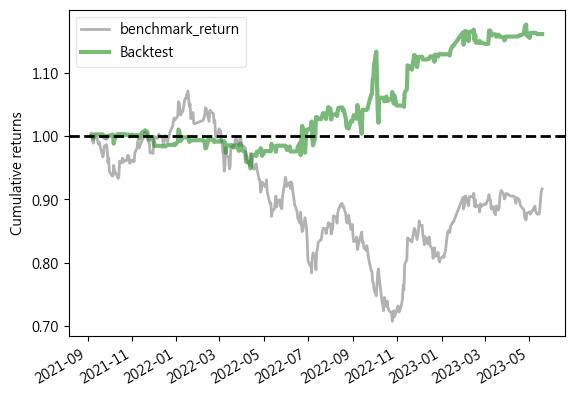

In [303]:
pf.plotting.plot_rolling_returns(returns, factor_returns=benchmark_rets)